# Assignment 3

All of this work was completed by Tyler Teufel. I would like to credit several different Youtube videos, online articles, and some brainstorming with chatGPT for the work completed. I was previously unfamilar with the large majority of the Python packages and code strategies for accomplishing these tasks, so I largely spent the majority of my time learning and researching.

## Question 1 - Part 1

### 1c.) Which embedding captures better semantics? Justify your answer.

Based upon the resulting similarity matrices, the embedding that best captured the semantics was the GloVe model. Upon analyzing the output of the cosine similarities that were calculated between each respective word pairing, the majority of the words in the matrix displayed numerical values tht best represented a far more clear cosine correlation amongst words commonly tied together conceptually, as opposed to a correlation coming from a vector magnitude, which would be more so tied to frequency. Words like 'dog' and 'bark' displayed much stronger correlation than the other words, as did 'money' and 'bank' - which are conceptually much more strongly related. On the other hand, there were a significant amount of negative values in the FastText matrix, which, assuming a correct implementation, paints a much different story.


### 1a.) Similarity Matrix

In [5]:
import gensim.downloader as api
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load the GloVe model with 50-dimensional vectors
wv = api.load('glove-twitter-50')

# Define the list of words
words = ['Dog', 'Bark', 'Tree', 'Bank', 'River', 'Money']

# Extract vectors for each word and handle missing words.
# This logic ensures that the words in 'words' are also in the model.
vectors = []
valid_words = []
for word in words:
    if word.lower() in wv:
        vectors.append(wv[word.lower()])
        valid_words.append(word)
    else:
        print(f"Word '{word}' not found in the GloVe vocabulary")

# Compute the cosine similarity matrix.

if vectors:
    # Ensure there are valid vectors to compute.
    similarity_matrix = cosine_similarity(vectors)

    # Display the matrix with words as labels for clarity
    print("\nCosine Similarity Matrix:")
    # Print evenly spaced column headers with each word in 'words', left aligned.
    print(f"{'':<10}", end='')
    for word in valid_words:
        print(f"{word:<10}", end='')
    print()
    for i, word in enumerate(valid_words):
        print(f"{word:<10}", end='')
        for j in range(len(valid_words)):
            print(f"{similarity_matrix[i][j]:<10.2f}", end='')
        print()
else:
    print("No valid words to compare.")


Cosine Similarity Matrix:
          Dog       Bark      Tree      Bank      River     Money     
Dog       1.00      0.59      0.71      0.35      0.40      0.58      
Bark      0.59      1.00      0.55      0.04      0.27      0.29      
Tree      0.71      0.55      1.00      0.35      0.49      0.51      
Bank      0.35      0.04      0.35      1.00      0.32      0.67      
River     0.40      0.27      0.49      0.32      1.00      0.34      
Money     0.58      0.29      0.51      0.67      0.34      1.00      


### 1b.) Fast Text

In [20]:
from gensim.models import FastText
from gensim.test.utils import common_texts
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
print(common_texts)

# Train the FastText model with the given configuration.
model_fasttext = FastText(sentences=common_texts, vector_size=50, window=5, min_count=1, epochs=10)

# List of words to analyze (as in your assignment).
words = ['dog', 'bark', 'tree', 'bank', 'river', 'money']

# Compute pairwise cosine similarity between words for FastText
similarities_fasttext = {}

for word1 in words:
    for word2 in words:
        # FastText can generate vectors for OOV words using subwords,
        # so we skip vocabulary checks.
        vec1 = model_fasttext.wv[word1]
        vec2 = model_fasttext.wv[word2]
        # Format the output such that it can be correctly formatted
        sim = cosine_similarity([vec1], [vec2])[0][0]
        similarities_fasttext[(word1, word2)] = sim

# Display the cosine similarity matrix
# Print FastText cosine similarity matrix
print("\nFastText Cosine Similarity Matrix:")
print(f"{'':<10}", end='')
for word in words:
    print(f"{word:<10}", end='')
print()
for i, word1 in enumerate(words):
    print(f"{word1:<10}", end='')
    for j, word2 in enumerate(words):
        sim = similarities_fasttext[(word1, word2)]
        print(f"{sim:<10.2f}", end='')
    print()

[['human', 'interface', 'computer'], ['survey', 'user', 'computer', 'system', 'response', 'time'], ['eps', 'user', 'interface', 'system'], ['system', 'human', 'system', 'eps'], ['user', 'response', 'time'], ['trees'], ['graph', 'trees'], ['graph', 'minors', 'trees'], ['graph', 'minors', 'survey']]

FastText Cosine Similarity Matrix:
          dog       bark      tree      bank      river     money     
dog       1.00      0.11      -0.17     0.03      -0.01     -0.11     
bark      0.11      1.00      0.21      0.17      0.09      -0.05     
tree      -0.17     0.21      1.00      0.04      0.07      -0.26     
bank      0.03      0.17      0.04      1.00      0.20      -0.02     
river     -0.01     0.09      0.07      0.20      1.00      -0.12     
money     -0.11     -0.05     -0.26     -0.02     -0.12     1.00      


### 2a.) - Splitting the Data into Training and Testing Sets

In [26]:
%pip install transformers datasets evaluate rouge_score

In [22]:
import nltk
from nltk.corpus import twitter_samples
from sklearn.model_selection import train_test_split

# Download the Twitter sample data if not already done
nltk.download('twitter_samples')

# Load the positive and negative tweets from the NLTK Twitter sample dataset
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

# Create labels (1 for positive, 0 for negative)
tweets = positive_tweets + negative_tweets
labels = [1] * len(positive_tweets) + [0] * len(negative_tweets)

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.3, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


Training set size: 7000
Testing set size: 3000


### 2b.) - Extracting N-grams for n in [1, 4]

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a function to extract n-gram features for different values of n
def extract_ngram_features(n, X_train, X_test):
    vectorizer = CountVectorizer(ngram_range=(1, n))
    X_train_ngram = vectorizer.fit_transform(X_train)
    X_test_ngram = vectorizer.transform(X_test)
    return X_train_ngram, X_test_ngram, vectorizer

# Extract features for unigrams, bigrams, trigrams, and 4-grams
X_train_unigram, X_test_unigram, vectorizer_unigram = extract_ngram_features(1, X_train, X_test)
X_train_bigram, X_test_bigram, vectorizer_bigram = extract_ngram_features(2, X_train, X_test)
X_train_trigram, X_test_trigram, vectorizer_trigram = extract_ngram_features(3, X_train, X_test)
X_train_4gram, X_test_4gram, vectorizer_4gram = extract_ngram_features(4, X_train, X_test)

### 2c.) - Building and Evaluating a Logistic Regression Model


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Function to train and evaluate a logistic regression model
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Evaluate models for different n-grams
accuracy_unigram = train_and_evaluate_model(X_train_unigram, X_test_unigram, y_train, y_test)
accuracy_bigram = train_and_evaluate_model(X_train_bigram, X_test_bigram, y_train, y_test)
accuracy_trigram = train_and_evaluate_model(X_train_trigram, X_test_trigram, y_train, y_test)
accuracy_4gram = train_and_evaluate_model(X_train_4gram, X_test_4gram, y_train, y_test)

# Print the accuracy results
print(f"Accuracy with Unigrams: {accuracy_unigram:}")
print(f"Accuracy with Bigrams: {accuracy_bigram:}")
print(f"Accuracy with Trigrams: {accuracy_trigram:}")
print(f"Accuracy with 4-grams: {accuracy_4gram:}")

Accuracy with Unigrams: 0.7633333333333333
Accuracy with Bigrams: 0.768
Accuracy with Trigrams: 0.7693333333333333
Accuracy with 4-grams: 0.769


### 2d.) - Analyzing the Effect of n on Model Performance


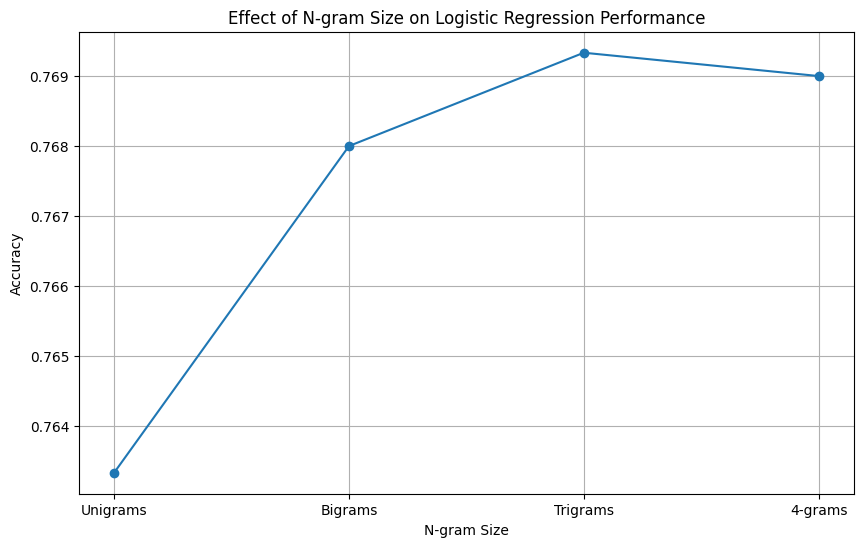

In [25]:
import matplotlib.pyplot as plt

# Plot n-gram performance
ngram_values = ['Unigrams', 'Bigrams', 'Trigrams', '4-grams']
accuracy_scores = [accuracy_unigram, accuracy_bigram, accuracy_trigram, accuracy_4gram]

plt.figure(figsize=(10, 6))
plt.plot(ngram_values, accuracy_scores, marker='o')
plt.title('Effect of N-gram Size on Logistic Regression Performance')
plt.xlabel('N-gram Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### Part d explaination

Based on the graph produced above, it can be clearly concluded that as the value of n increases, the accuracy shows to increase, aside from the jump from n=3 to n=4. Nonetheless, this shows that with an increase in N-grams, the higher the accuracy.

## Section 2

A variation in both sequence length and hyperparamters both on a large scale provide positive improvements to the model. For the variation in sequence lengths, increases in the sequence lengths can allow for the model to consider more information, at the cost of increased computational requirements. The variation in time my program took to run was a minimum of around 20-25 minutes, and a high of 1 hour.

Regarding the alterations in hyperparamters, testing a variation of hyperparamters requires a bit of trial and error to finetune the perfect situation. Overtime, optimized outputs can be found leading to significantly better output values.

In [ ]:
%pip install tensorflow datasets nltk

### Question 2

In [3]:
# Imports
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu

# Function to prepare sequences for input and output.
def prepare_sequences(data, input_tokenizer, output_tokenizer, input_max_len, output_max_len):
    input_sequences = pad_sequences(input_tokenizer.texts_to_sequences(data['text']),
                                    maxlen=input_max_len, padding='post')
    output_sequences = pad_sequences(output_tokenizer.texts_to_sequences(data['summary']),
                                     maxlen=output_max_len, padding='post')
    return input_sequences, output_sequences

# Function to evaluate BLEU score.
def evaluate_bleu(model, test_data, input_tokenizer, output_tokenizer, input_max_len, output_max_len):
    bleu_scores = []
    reverse_output_index = {v: k for k, v in output_tokenizer.word_index.items()}

    for _, sample in test_data.iterrows():
        input_seq = input_tokenizer.texts_to_sequences([sample['text']])
        input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')

        # Generate prediction.
        prediction = model.predict([input_seq, np.zeros((1, output_max_len))])
        pred_tokens = np.argmax(prediction, axis=-1)[0]

        # Convert tokens to words.
        pred_summary = ' '.join([reverse_output_index.get(token, '') for token in pred_tokens if token > 0])
        target_summary = sample['summary']

        # Compute BLEU score.
        bleu_score = sentence_bleu([target_summary.split()], pred_summary.split())
        bleu_scores.append(bleu_score)

    average_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f"Average BLEU score: {average_bleu:.4f}")

# Load and split the dataset.
billsum = load_dataset("billsum", split="ca_test")
billsum_df = pd.DataFrame(billsum)
train_data, test_data = train_test_split(billsum_df, test_size=0.2, random_state=42)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

# Tokenization and sequence prep.
input_tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
output_tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')

input_tokenizer.fit_on_texts(train_data['text'])
output_tokenizer.fit_on_texts(train_data['summary'])

# Max input & output.
input_max_len = 1024
output_max_len = 128

X_train, y_train = prepare_sequences(train_data, input_tokenizer, output_tokenizer, input_max_len, output_max_len)
X_test, y_test = prepare_sequences(test_data, input_tokenizer, output_tokenizer, input_max_len, output_max_len)

# Build  Seq2Seq model.
embedding_dim = 128
num_neurons = 256
dropout_rate = 0.3
vocab_size_input = len(input_tokenizer.word_index) + 1
vocab_size_output = len(output_tokenizer.word_index) + 1

# Encoder.
encoder_inputs = Input(shape=(input_max_len,), name="encoder_inputs")
encoder_embedding = Embedding(input_dim=vocab_size_input, output_dim=embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(num_neurons, return_state=True, dropout=dropout_rate)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder.
decoder_inputs = Input(shape=(output_max_len,), name="decoder_inputs")
decoder_embedding = Embedding(input_dim=vocab_size_output, output_dim=embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(num_neurons, return_sequences=True, return_state=True, dropout=dropout_rate)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Compile the model.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Prepare decoder input and target data with consistent shapes.
# Use the full padded sequence for decoder inputs.
decoder_input_data = y_train
decoder_target_data = np.pad(y_train[:, 1:], ((0, 0), (0, 1)), 'constant')

# Train the model with consistent shapes
history = model.fit(
    [X_train, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=5,
    validation_split=0.2
)

# Evaluate the model using BLEU score
evaluate_bleu(model, test_data, input_tokenizer, output_tokenizer, input_max_len, output_max_len)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/91.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.8M [00:00<?, ?B/s]

ca_test-00000-of-00001.parquet:   0%|          | 0.00/6.12M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18949 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3269 [00:00<?, ? examples/s]

Generating ca_test split:   0%|          | 0/1237 [00:00<?, ? examples/s]

Number of training samples: 989
Number of testing samples: 248


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 1024)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1024, 128)      │      3,013,760 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 1024)           │              0 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 128, 128)       │      1,114,112 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 256), (None,   │        394,240 │ embedding[0][0],       │
│                           │ 256), (None, 256)]     │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 128, 256),     │        394,240 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128, 8704)      │      2,236,928 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,153,280 (27.29 MB)

 Trainable params: 7,153,280 (27.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 180s 14s/step - accuracy: 0.0500 - loss: 8.9070 - val_accuracy: 0.0742 - val_loss: 7.0125
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 187s 12s/step - accuracy: 0.0756 - loss: 6.5127 - val_accuracy: 0.0742 - val_loss: 6.1143
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 210s 13s/step - accuracy: 0.0747 - loss: 6.0737 - val_accuracy: 0.0742 - val_loss: 6.0432
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 195s 12s/step - accuracy: 0.0764 - loss: 5.9552 - val_accuracy: 0.0742 - val_loss: 6.0215
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 200s 12s/step - accuracy: 0.0763 - loss: 5.9179 - val_accuracy: 0.0742 - val_loss: 6.0115
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 